In [1]:
# 全局设置
import sys
import datetime as dt

import numpy as np
import pandas as pd

import QuantStudio.api as QS
fd = QS.FactorDB.FactorTools

HDB = QS.FactorDB.HDF5DB(config_file="../config/HDF5DBConfig.json").connect();

# 因子测试

**Rank IC**：往期因子值和当期收益率的秩相关性。通常采用的相关系数为 Spearman 相关系数。记收益率的横截面向量 $R_{i,t}$ 的截面排名记为 $Q_{i,t}$, 在 $t-1$ 时刻因子暴露的横截面向量 $\beta_{i,t}$ 的截面排名记为 $P_{i,t}$, 那么 $t$ 时刻的 Rank IC 定义为: 
$$
\rho \left( Q_{t},P_{t-1} \right) = \frac{\sum\limits_{i=1}^{N}{\left( Q_{i,t} - \bar{Q}_{t} \right) \left( P_{i,t-1}-\bar{P}_{t-1} \right)}}{\sqrt{\sum\limits_{i=1}^{N}{{{\left( Q_{i,t} - \bar{Q}_{t} \right)}^{2}}}\cdot \sum\limits_{i=1}^{N}{{{\left( P_{i,t-1}-\bar{P}_{t-1} \right)}^{2}}}}}
$$
其中: 
$$
\begin{aligned}
& \bar{Q}_{t} = \frac{1}{N}\sum\limits_{i=1}^{N}Q_{i,t}\\
& \bar{P}_{t-1} = \frac{1}{N}\sum\limits_{i=1}^{N}P_{i,t-1}
\end{aligned}
$$
另外还可以计算行业调整的 IC：扣除行业收益率后的 Rank IC. 对于股票 i, 其收益率 $R_{i,t}$ 的行业调整值定义为 $\tilde{R}_{i,t}=R_{i,t}-R_{I,t}$, 其中, $R_{I,t}$ 为行业 I 在时段 $[t-1,t]$ 的收益率, 即 $R_{I,t}=\sum\limits_{i\in I}{w_{i,t-1}\cdot R_{i,t}}$, $w_{i,t}$ 为 t 时刻股票 i 在行业 I 中所占的权重, 通常可取等权或者按照某个指标加权。对于因子 j , 行业调整的 Rank IC 即为调整后的收益率 $\tilde{R}_{i,t}$ 同 $\beta_{j,t}$ 的 Rank IC。

**IC的衰减**：因子值和收益率关于日期间隔的衰减情况。对于因子 j，分别计算 $R_t$ 同 $\beta _{j,t-1},\beta _{j,t-2},\ldots ,\beta _{j,t-K}$ 的Rank IC, 考察 Rank IC 序列关于时间间隔 $\left(1,2,\ldots ,K \right)$ 的变化情况。

**分位数组合**：按因子值排序分组后形成的投资组合. 对于目标因子, 在时刻 t，首先剔除因子值缺失和不符合筛选条件的证券，对剩下的证券按照因子暴露进行排序，把排序后的证券平均分成 K 组（一般取 5 或者 10 组），每一组构建投资组合（通常为等权或者按照某个因子值加权），测试给定时间段每一组合的表现情况。计算每一组的收益率，年化收益率，波动率等指标。

**因子换手率**：当期因子值和上期因子值横截面上的线性相关系数。对于给定因子，因子暴露的横截面向量 $\beta_{i,t}$ 的截面排名记为 $P_{i,t}$，日期 t 和上一日期 t-1 之间的换手率定义为: 
$$
\rho \left( P_{t}, P_{t-1} \right) = \frac{\sum\limits_{i=1}^{N}{\left( P_{i,t} - \bar{P}_{t} \right) \left( P_{i,t-1} - \bar{P}_{t-1} \right)}} {\sqrt{\sum\limits_{i=1}^{N}{{{\left( P_{i,t}-\bar{P}_{t} \right)}^{2}}}\cdot \sum\limits_{i=1}^{N}{{{\left( P_{i,t-1}-\bar{P}_{t-1} \right)}^{2}}}}}
$$

**因子值行业分布**：每个时刻, 每个行业内, 因子暴露超过某个阈值的股票比例. 阈值可以设置为所有因子暴露的平均值、中位数、25% 分位数、75% 分位数, 在时刻 t , 对于行业 I , 行业 I 内的股票数为 $N_{I,t}$, 行业 I 内因子值超过阈值的股票数为 $\tilde{N}_{I,t}$ , 则行业 I 的因子值分布为 ${}^{\tilde{N}_{I,t}}/{}_{N_{I,t}}$。 

**Fama-MacBeth 回归**：剥离了给定风险因子后的因子收益率. 给定 K 个风险因子（一般取市值, Beta, 行业等）, 记股票 i 在这些风险因子上的暴露为 $\beta_{i,1,t},\beta_{i,2,t},\ldots ,\beta_{i,K,t}$ , 对于目标因子, 在时刻 t , 同风险因子一起与收益率向量 $\mathbf{R}_t$ 做横截面回归, 即: 
$$
R_{i,t} = f^*_{t}\beta^*_{i,t-1} + f_{1,t}\cdot \beta_{i,1,t-1}+ \cdots +f_{K,t}\cdot \beta_{i,K,t-1} + \varepsilon_{i,t}
$$
估计的回归系数 $f^*_{t}$ 即为剥离了这 K 个风险因子后目标因子在时段 t 的收益。 

**因子相关性**：前后两期因子暴露的相关性. 取时刻 t 的因子 i 和因子 j 的因子暴露 $\beta_{i,t}$、$\beta_{j,t}$ , 在横截面上计算相关性, 方法可以选择: spearman, pearson, kendall 以及 factor-score correlation. 

In [2]:
# 参数设置
StartDT, EndDT = dt.datetime(2014, 1, 1), dt.datetime(2019, 4, 30)# 数据起止时间
TestStartDT, TestEndDT = dt.datetime(2017, 1, 1), EndDT# 测试起止时间


FT = HDB.getTable("stock_cn_day_bar_adj_backward_nafilled")
DTs = FT.getDateTime(start_dt=StartDT, end_dt=EndDT)
TestDTs = FT.getDateTime(start_dt=TestStartDT, end_dt=TestEndDT)
IDs = FT.getID()

# 再平衡时点序列
# BalanceDTs = DTs
BalanceDTs = QS.Tools.DateTime.getMonthLastDateTime(DTs)# 月末
# BalanceDTs = QS.Tools.DateTime.getWeekLastDateTime(DTs)# 周末
# BalanceDTs = QS.Tools.DateTime.getQuarterLastDateTime(DTs)# 季末
# BalanceDTs = QS.Tools.DateTime.getYearLastDateTime(DTs)# 年末

==========历史回测==========
1. 初始化
耗时 : 47.30
2. 循环计算


100% (566 of 566) |######################| Elapsed Time: 0:25:05 Time:  0:25:05


耗时 : 1506.56
3. 结果生成
耗时 : 0.86
总耗时 : 1554.72



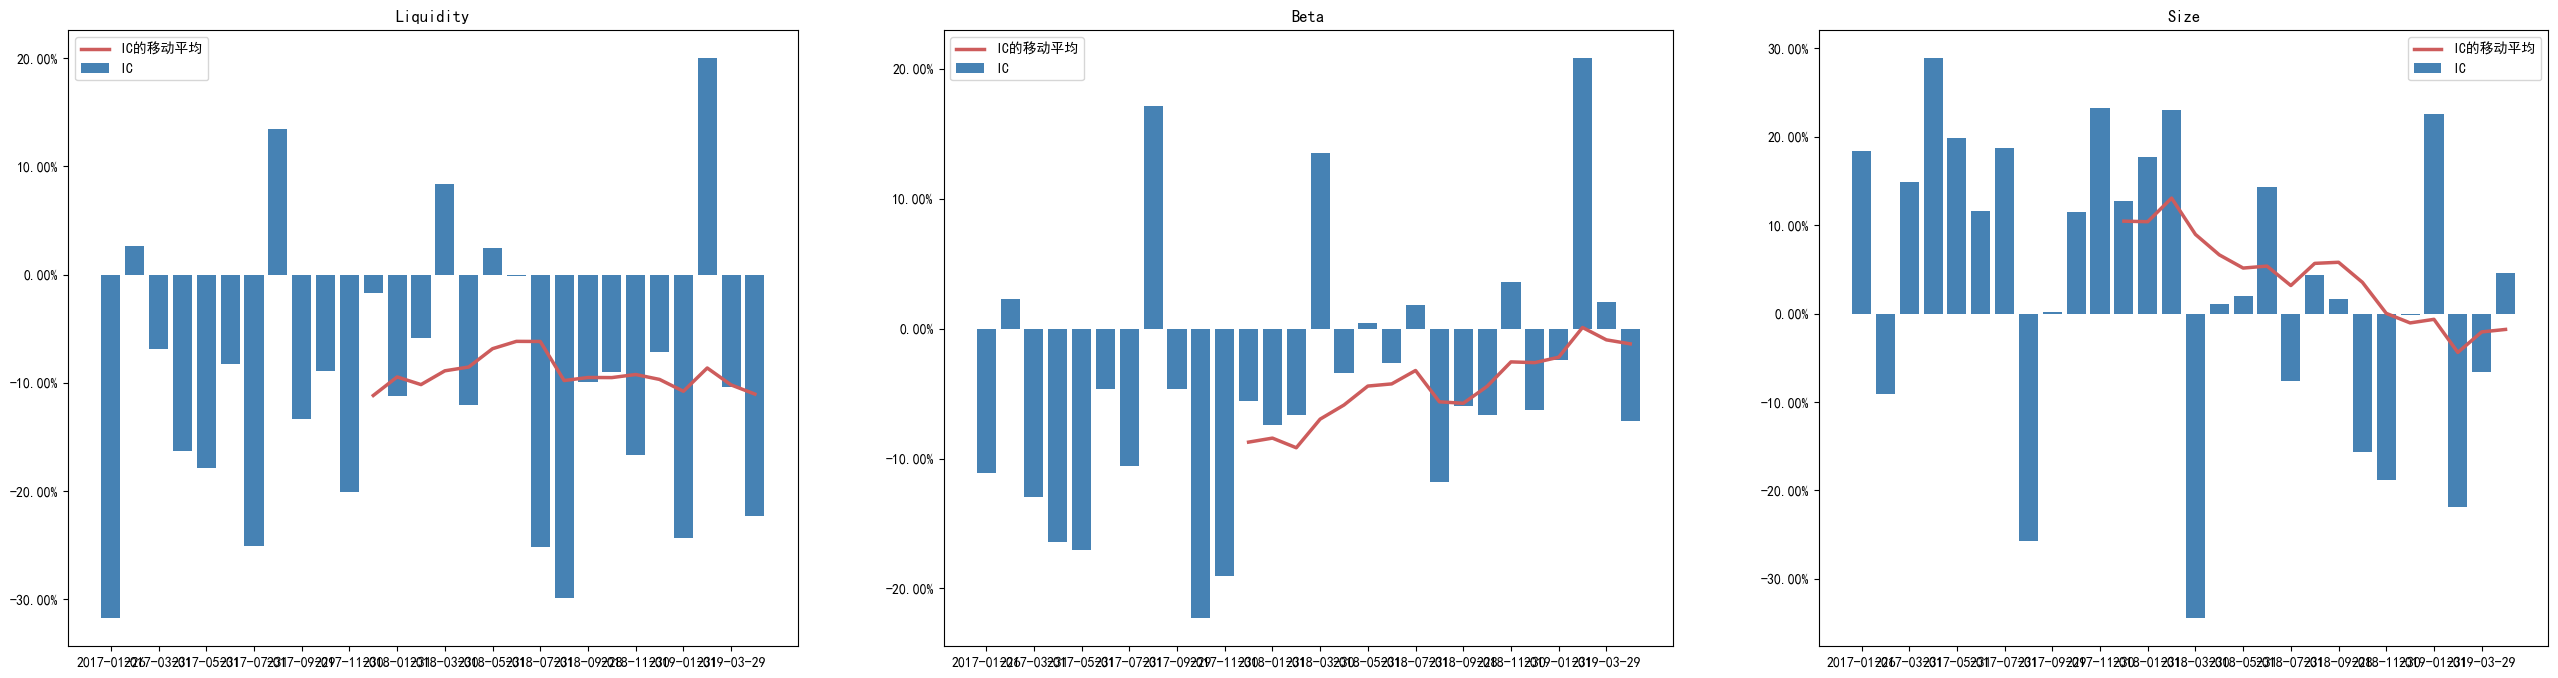
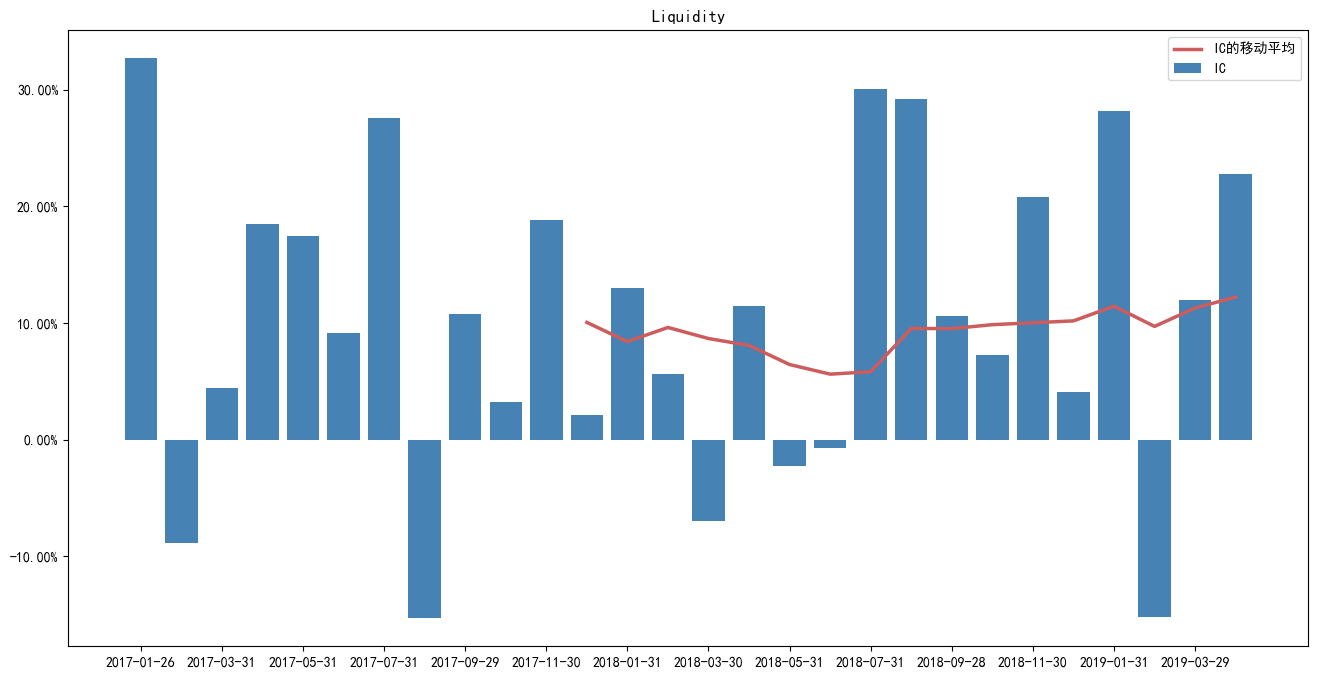
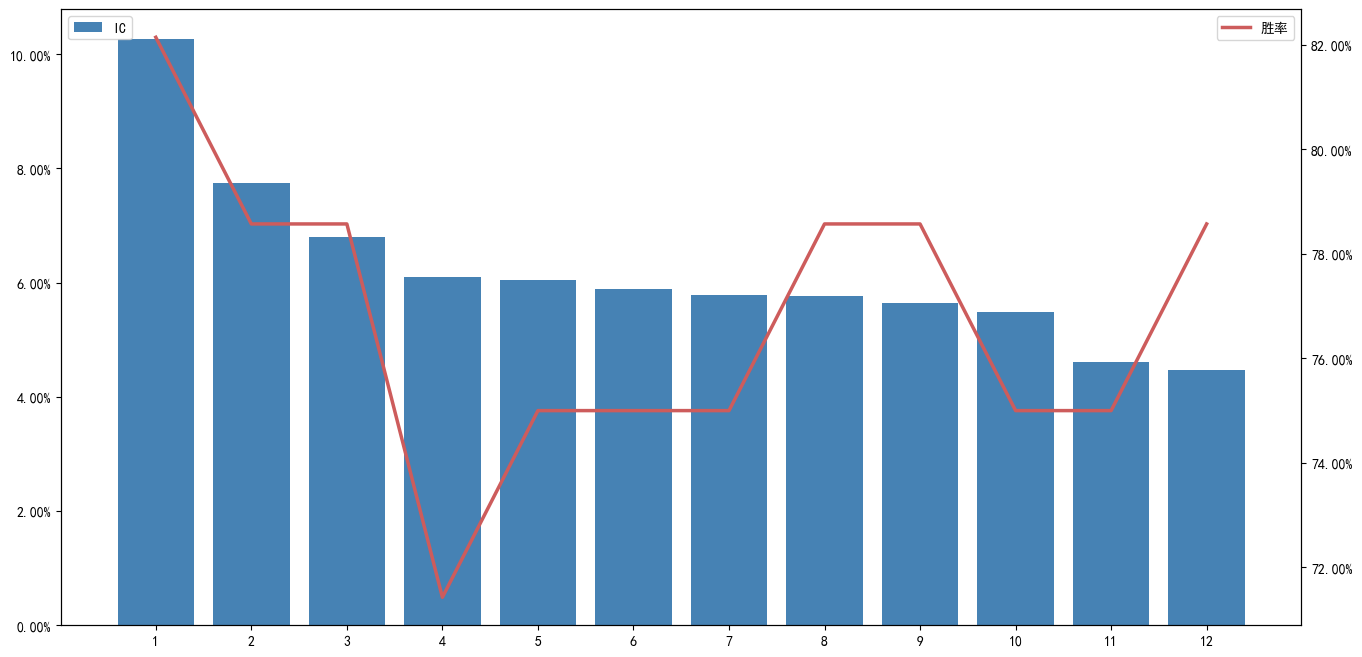
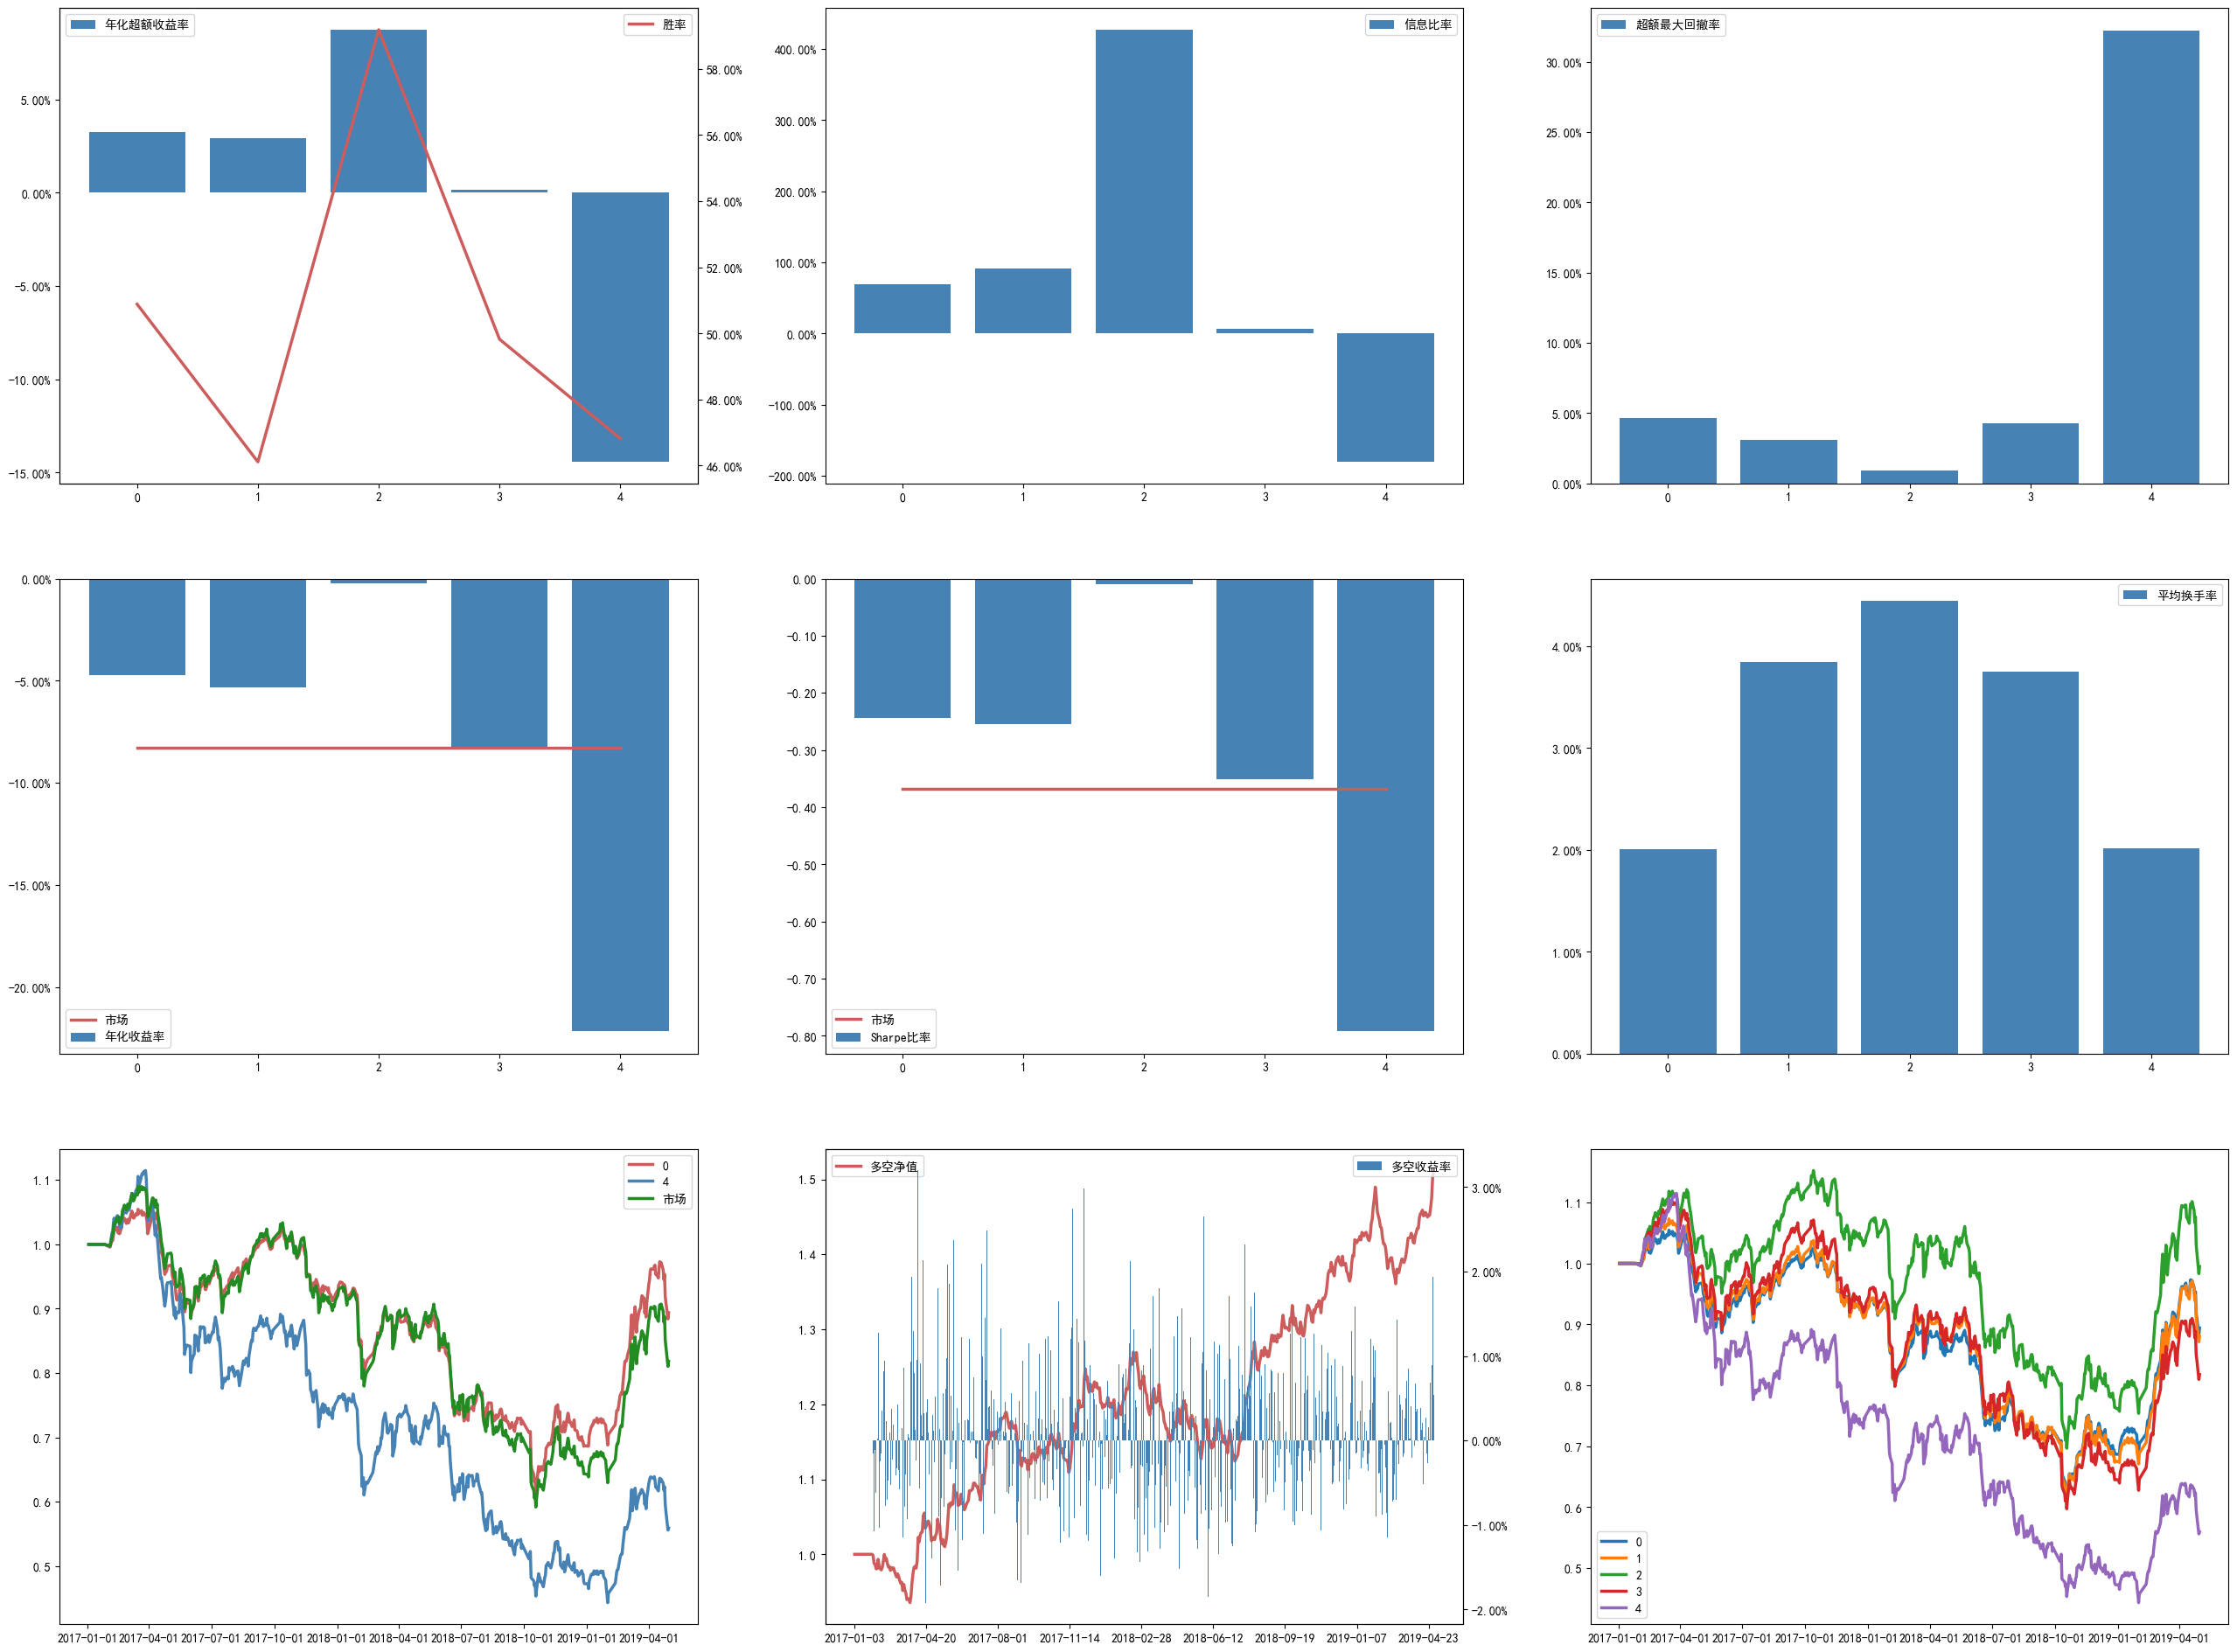
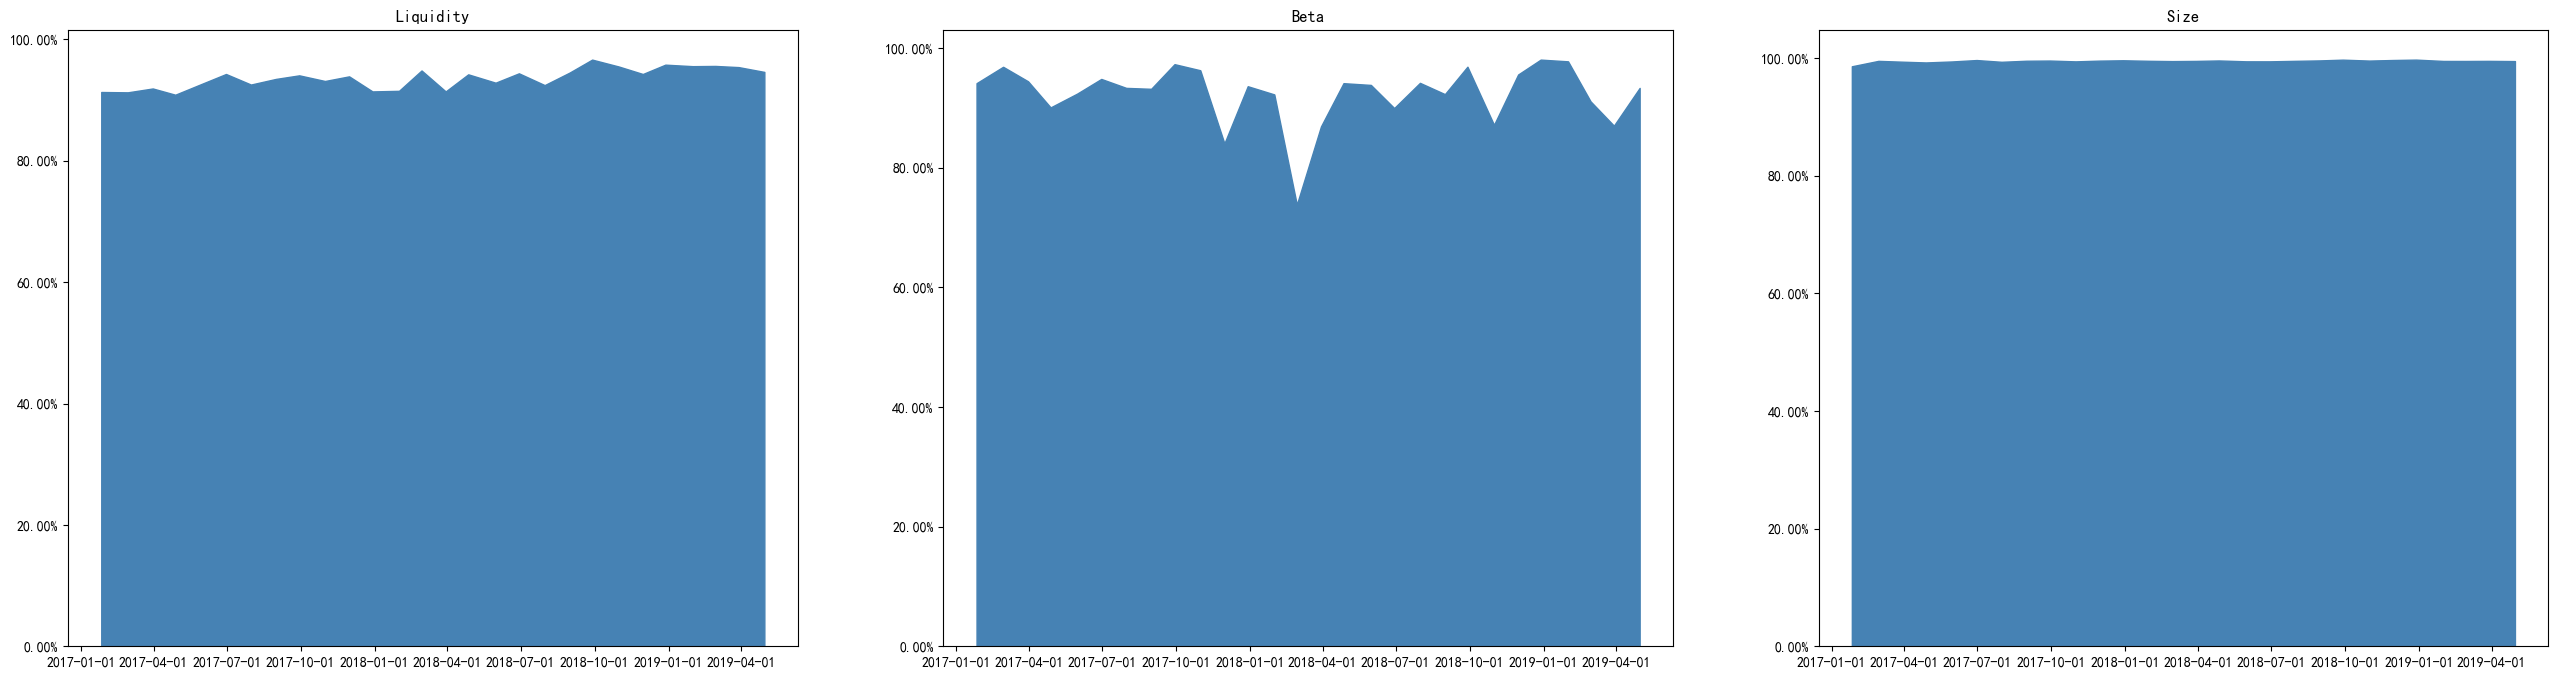
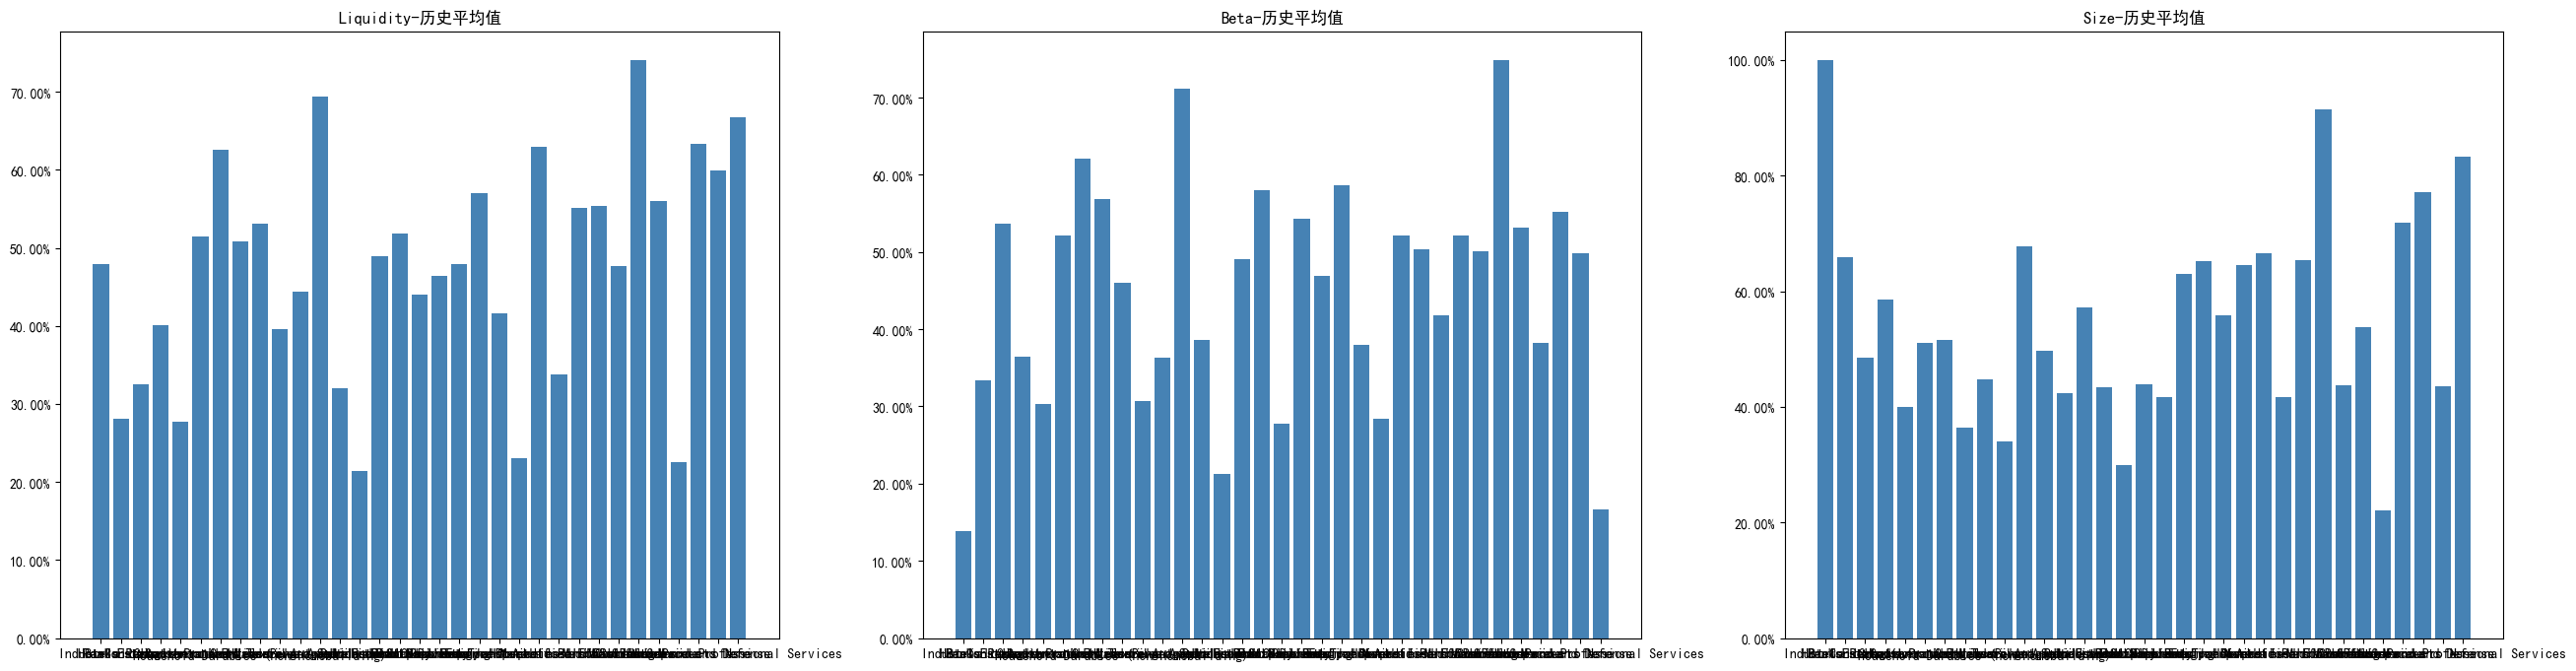
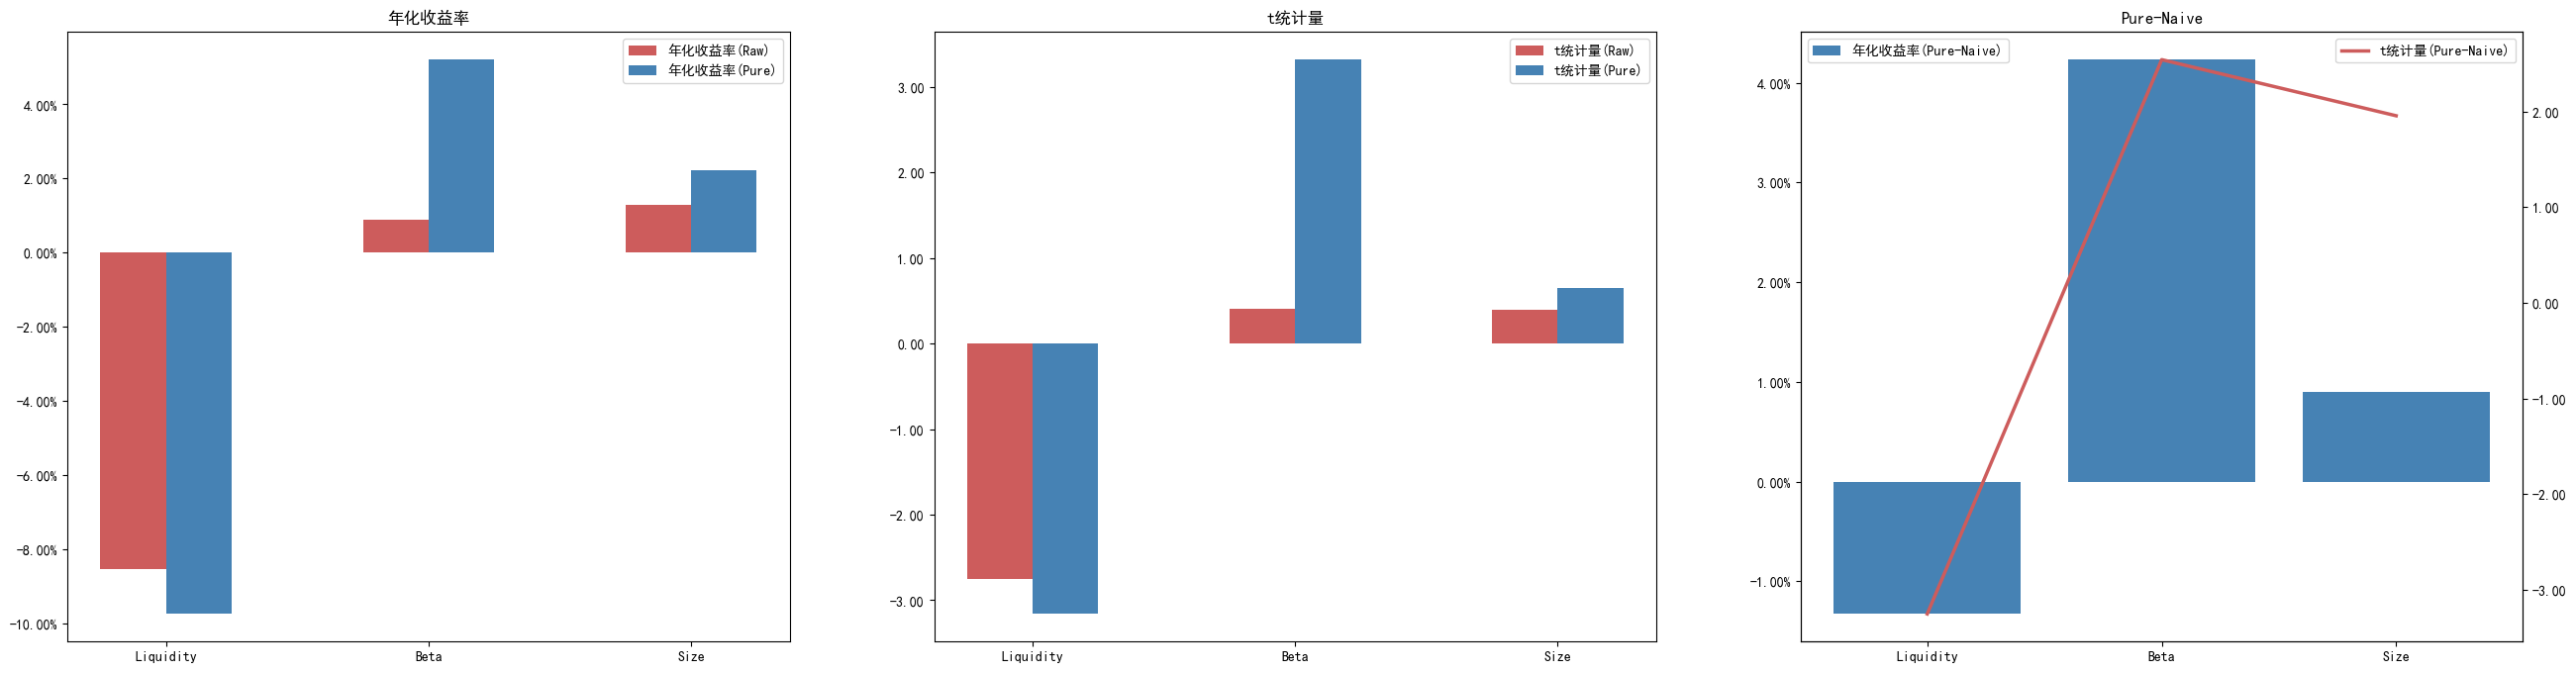

In [3]:
# 因子测试
# 创建自定义因子表
CFT = QS.FactorDB.CustomFT("CFT")
CFT.Args["遍历模式"]["向后缓冲时点数"] = 60
FT = HDB.getTable("stock_cn_factor_barra")
TargetFactors = ["Liquidity", "Beta", "Size"]
CFT.addFactors(factor_table=FT, factor_names=TargetFactors)

FT = HDB.getTable("stock_cn_day_bar_nafilled")
CFT.addFactors(factor_table=FT, factor_names=["if_trading"])

FT = HDB.getTable("stock_cn_day_bar_adj_backward_nafilled")
CFT.addFactors(factor_table=FT, factor_names=["close"])

FT = HDB.getTable("stock_cn_factor_barra_descriptor")
CFT.addFactors(factor_table=FT, factor_names=["Industry"], args={})

CFT.setDateTime(DTs)
CFT.setID(IDs)

# 创建回测模型
Model = QS.BackTest.BackTestModel()

# --------因子测试模块--------
# IC 测试
iModule = QS.BackTest.SectionFactor.IC(factor_table=CFT)
iModule.Args["筛选条件"] = "@if_trading==1"
iModule.Args["测试因子"] = TargetFactors
iModule.Args["排序方向"] = {iFactor: "降序" for iFactor in TargetFactors}
iModule.Args["价格因子"] = "close"
iModule.Args["类别因子"] = "Industry"
iModule.Args["权重因子"] = "等权"
iModule.Args["计算时点"] = BalanceDTs
iModule.Args["回溯期数"] = 1
iModule.Args["相关性算法"] = "spearman"
iModule.Args["滚动平均期数"] = 12
Model.Modules.append(iModule)

# 风险调整的 IC
iModule = QS.BackTest.SectionFactor.RiskAdjustedIC(factor_table=CFT)
iModule.Args["筛选条件"] = "@if_trading==1"
iModule.Args["测试因子"] = ["Liquidity"]
iModule.Args["排序方向"] = {"Liquidity": "升序"}
iModule.Args["价格因子"] = "close"
iModule.Args["类别因子"] = "Industry"
iModule.Args["风险因子"] = ["Beta", "Size"]
iModule.Args["计算时点"] = BalanceDTs
iModule.Args["回溯期数"] = 1
iModule.Args["相关性算法"] = "spearman"
iModule.Args["滚动平均期数"] = 12
Model.Modules.append(iModule)

# IC 的衰减
iModule = QS.BackTest.SectionFactor.ICDecay(factor_table=CFT)
iModule.Args["筛选条件"] = "@if_trading==1"
iModule.Args["测试因子"] = "Liquidity"
iModule.Args["排序方向"] = "升序"
iModule.Args["价格因子"] = "close"
iModule.Args["类别因子"] = "Industry"
iModule.Args["权重因子"] = "等权"
iModule.Args["计算时点"] = BalanceDTs
iModule.Args["回溯期数"] = np.arange(1,13).tolist()
iModule.Args["相关性算法"] = "spearman"
Model.Modules.append(iModule)

# 分位数组合测试
iModule = QS.BackTest.SectionFactor.QuantilePortfolio(factor_table=CFT, name="Liquidity-分位数组合测试")
iModule.Args["筛选条件"] = "@if_trading==1"
iModule.Args["测试因子"] = "Liquidity"
iModule.Args["排序方向"] = "升序"
iModule.Args["分组数"] = 5
iModule.Args["价格因子"] = "close"
iModule.Args["类别因子"] = "Industry"
iModule.Args["权重因子"] = "等权"
iModule.Args["调仓时点"] = BalanceDTs
iModule.Args["市场组合"] = "@if_trading==1"
Model.Modules.append(iModule)# 对每个因子单独进行分位数组合测试

# 因子截面相关性
iModule = QS.BackTest.SectionFactor.SectionCorrelation(factor_table=CFT)
iModule.Args["筛选条件"] = "@if_trading==1"
iModule.Args["测试因子"] = TargetFactors
iModule.Args["排序方向"] = {iFactor: "降序" for iFactor in TargetFactors}
iModule.Args["计算时点"] = BalanceDTs
iModule.Args["相关性算法"] = ["spearman"]
Model.Modules.append(iModule)

# 因子换手率
iModule = QS.BackTest.SectionFactor.FactorTurnover(factor_table=CFT)
iModule.Args["筛选条件"] = "@if_trading==1"
iModule.Args["测试因子"] = TargetFactors
iModule.Args["计算时点"] = BalanceDTs
Model.Modules.append(iModule)

# 因子值的行业分布
iModule = QS.BackTest.SectionFactor.IndustryDistribution(factor_table=CFT)
iModule.Args["筛选条件"] = "@if_trading==1"
iModule.Args["测试因子"] = TargetFactors
iModule.Args["行业因子"] = "Industry"
iModule.Args["阈值"] = "中位数"
iModule.Args["计算时点"] = BalanceDTs
Model.Modules.append(iModule)

# Fama-MacBeth 回归
iModule = QS.BackTest.SectionFactor.FamaMacBethRegression(factor_table=CFT)
iModule.Args["筛选条件"] = "@if_trading==1"
iModule.Args["测试因子"] = TargetFactors
iModule.Args["价格因子"] = "close"
iModule.Args["类别因子"] = "Industry"
iModule.Args["计算时点"] = BalanceDTs
iModule.Args["滚动平均期数"] = 12
Model.Modules.append(iModule)


# 运行模型
Model.run(dts=TestDTs, subprocess_num=0)

# 查看结果
display(Model)

# 对比测试

==========历史回测==========
1. 初始化
耗时 : 0.01
2. 循环计算


100% (566 of 566) |######################| Elapsed Time: 0:17:52 Time:  0:17:52


耗时 : 1073.43
3. 结果生成
耗时 : 1.84
总耗时 : 1075.29


,总收益率,年化收益率,波动率,Sharpe比率,t统计量(Sharpe比率),平均换手率,最大回撤率,最大回撤开始时间,最大回撤结束时间,超额收益率,年化超额收益率,跟踪误差,信息比率,t统计量(信息比率),胜率,超额最大回撤率,超额最大回撤开始时间,超额最大回撤结束时间,CAPM Alpha,CAPM Beta
0-Liquidity,-0.439409,-0.220738,0.279137,-0.790788,-0.45562,0.019989,0.6016,2017-03-27,2019-01-31,-0.302007,-0.143533,0.079383,-1.808119,-2.75437,0.469965,0.320695,2017-03-27,2019-04-30,-0.00056,1.204408
1-Beta,-0.258127,-0.120733,0.266653,-0.452771,-0.091523,0.023383,0.518115,2017-03-16,2018-10-18,-0.080074,-0.035327,0.049735,-0.710308,-1.082036,0.503534,0.118641,2017-03-07,2019-01-31,-0.000086,1.176695
2-Size,-0.061301,-0.026893,0.197017,-0.1365,0.249152,0.008585,0.370807,2017-11-13,2018-10-18,0.120901,0.050413,0.068768,0.733095,1.116748,0.443463,0.110368,2018-02-06,2019-04-22,0.000177,0.836854
,总收益率,年化收益率,波动率,Sharpe比率,t统计量(Sharpe比率),平均换手率,最大回撤率,最大回撤开始时间,最大回撤结束时间,超额收益率,年化超额收益率,跟踪误差,信息比率,t统计量(信息比率),胜率,超额最大回撤率,超额最大回撤开始时间,超额最大回撤结束时间,CAPM Alpha,CAPM Beta
0-Liquidity,-0.10613,-0.047198,0.192968,-0.244591,0.132721,0.020188,0.414771,2017-03-16,2018-10-18,0.077332,0.03262,0.046819,0.696725,1.061345,0.508834,0.04521,2017-12-05,2018-07-13,0.00009,0.845366
1-Beta,-0.227755,-0.105398,0.172968,-0.609349,-0.260181,0.023649,0.438484,2017-03-24,2018-10-18,-0.07385,-0.03252,0.06607,-0.492207,-0.749796,0.448763,0.149581,2018-02-06,2019-04-24,-0.000207,0.751864
2-Size,0.004593,0.001977,0.25971,0.007611,0.404383,0.013632,0.429163,2017-03-21,2018-10-18,0.250544,0.101142,0.061408,1.64705,2.509008,0.577739,0.074851,2017-03-22,2017-08-02,0.00043,1.130112
,总收益率,年化收益率,波动率,Sharpe比率,t统计量(Sharpe比率),平均换手率,最大回撤率,最大回撤开始时间,最大回撤结束时间,超额收益率,年化超额收益率,跟踪误差,信息比率,t统计量(信息比率),胜率,超额最大回撤率,超额最大回撤开始时间,超额最大回撤结束时间,CAPM Alpha,CAPM Beta
0-Liquidity,-0.360254,-0.175098,0.122229,-1.432537,-1.146887,NaN,0.400456,2017-03-27,2019-04-30,-0.275172,-0.129496,0.174015,-0.744165,-1.133613,0.432862,0.432605,2018-10-18,2019-04-19,-0.00067,0.351862
1-Beta,-0.023254,-0.010088,0.112061,-0.090024,0.299215,NaN,0.202294,2017-03-07,2018-02-06,0.109013,0.045598,0.142067,0.320961,0.488931,0.464664,0.301141,2018-10-18,2019-04-17,0.00009,0.425542

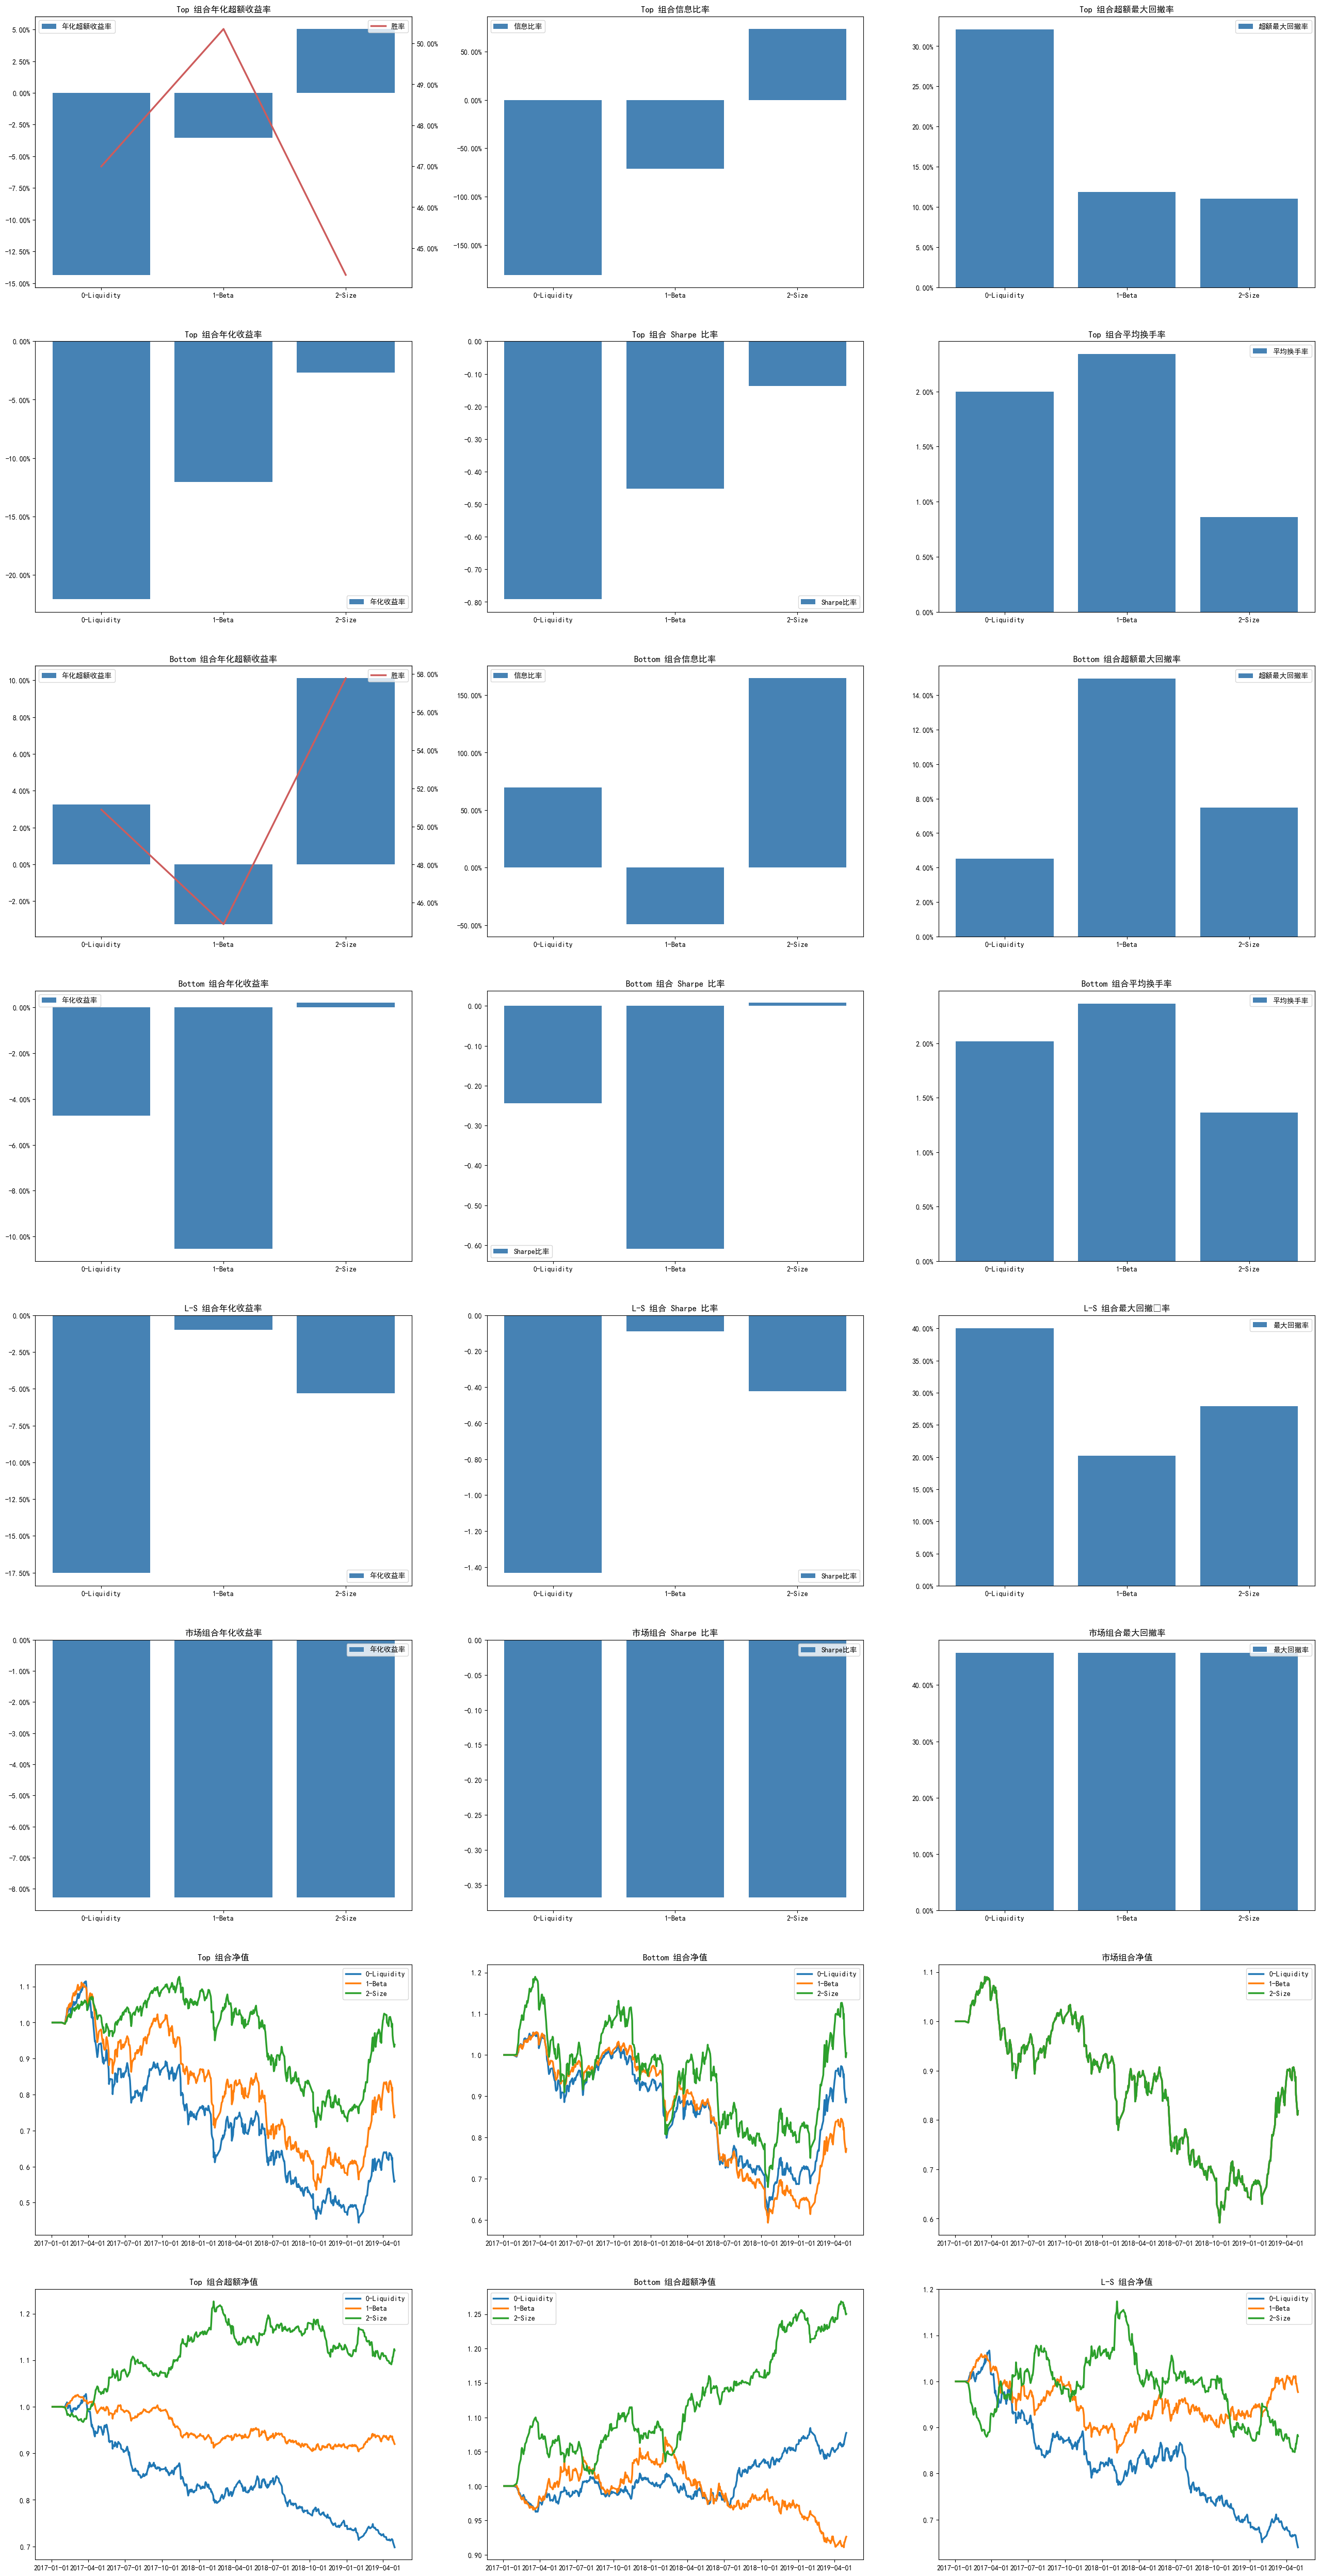

In [4]:
# 因子对比测试
# 创建回测模型
Model = QS.BackTest.BackTestModel()

# --------因子测试模块--------
# 分位数组合测试
iModule = QS.BackTest.SectionFactor.MultiPortfolio()
for i, iFactorName in enumerate(TargetFactors):
    iSubModule = QS.BackTest.SectionFactor.QuantilePortfolio(factor_table=CFT, name=iFactorName)
    iSubModule.Args["筛选条件"] = "@if_trading==1"
    iSubModule.Args["测试因子"] = iFactorName
    iSubModule.Args["排序方向"] = "降序"
    iSubModule.Args["分组数"] = 5
    iSubModule.Args["价格因子"] = "close"
    iSubModule.Args["类别因子"] = "Industry"
    iSubModule.Args["权重因子"] = "等权"
    iSubModule.Args["调仓时点"] = BalanceDTs
    iSubModule.Args["市场组合"] = "@if_trading==1"
    iModule.Modules.append(iSubModule)
Model.Modules.append(iModule)# 对多个因子进行分位数组合对比测试

# 运行模型
Model.run(dts=TestDTs)

# 查看结果
display(Model)